In [1]:
#---------------------------------------------------------------------------------------------------------------
# MODULES
#---------------------------------------------------------------------------------------------------------------
import copy
import numpy as np
import pandas as pd

def geography(left, right, bottom, top):
    resolution = 12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution 
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    upperindex = int((90-top)*resolution)
    lowerindex = int((90-bottom)*resolution)
    leftindex = int((180+left)*resolution)
    rightindex = int((180+right)*resolution)
    return img_extent, rgnshape, upperindex, lowerindex, leftindex, rightindex

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
def lonlat2xy(loncnt, latcnt, a=2160, b=4320):
    if -180 <= loncnt <=180:
        lon_middle = int(((loncnt+180)/360)*b )
        lat_middle = int(((90-latcnt)/180)*a ) 
    else:
        lon_middle = 1e20
        lat_middle = 1e20
    return lon_middle, lat_middle
    
def explore_prf(citymask, rivnum, elevation, rivara):
    """
    citymask:  g_mask_cropped,             city_mask
    rivnum:    g_rivnum_cropped_city,      city_mask内のrivnumデータ
    elevation: g_elv_cropped,              elevationデータ
    rivara:    g_rivara_cropped,           rivaraデータ
    """
    unique_values, counts = np.unique(rivnum.compressed(), return_counts=True)
    uid_dict = dict(zip(unique_values, counts))
    max_key = max(uid_dict, key=uid_dict.get)
    if max_key > 1:
        elv_indices = np.argwhere(rivnum == max_key)
        elv_values = [elevation[coord[0], coord[1]] for coord in elv_indices]
        elv_maxarg = np.argmax(elv_values)
        josui_coord = elv_indices[elv_maxarg]
        josui_array = np.zeros(rivnum.shape, dtype='float32')
        josui_array[josui_coord[0], josui_coord[1]] = max_key
        ara_indices = np.argwhere((citymask == 1) & (josui_array != rivnum[josui_coord[0], josui_coord[1]]))
        ara_values = [rivara[coord[0], coord[1]] for coord in ara_indices]
        if ara_values:
            ara_argmax = np.argmax(ara_values)
            gesui_coord = ara_indices[ara_argmax]
        else:
            print(f"ara_indices is empty -> argmin_elv for gesui")
            elv_minarg = np.argmax(elv_values)
            gesui_coord = elv_indices[elv_minarg]
    else:
        elv_indices = np.argwhere(citymask == 1)
        elv_values = [elevation[coord[0], coord[1]] for coord in elv_indices]
        elv_maxarg = np.argmax(elv_values)
        josui_coord = elv_indices[elv_maxarg]
        josui_array = np.zeros(rivnum.shape, dtype='float32')
        josui_array[josui_coord[0], josui_coord[1]] = rivnum[josui_coord[0], josui_coord[1]]
        ara_indices = np.argwhere((citymask == 1) & (josui_array != rivnum[josui_coord[0], josui_coord[1]]))
        ara_values = [rivara[coord[0], coord[1]] for coord in ara_indices]
        if ara_values:
            ara_argmax = np.argmax(ara_values)
            gesui_coord = ara_indices[ara_argmax]
        else:
            print(f"ara_indices is empty -> argmin_elv for gesui")
            elv_minarg = np.argmax(elv_values)
            gesui_coord = elv_indices[elv_minarg]
    gesui_array = np.ma.masked_all(rivnum.shape, dtype='float32')
    gesui_array[gesui_coord[0], gesui_coord[1]] = rivnum[gesui_coord[0], gesui_coord[1]]
    josui_array = np.ma.masked_all(rivnum.shape, dtype='float32')
    josui_array[josui_coord[0], josui_coord[1]] = rivnum[josui_coord[0], josui_coord[1]]
    
    return josui_array, gesui_array

def get_updown_rivpath(city_num, upperindex, lowerindex, leftindex, rightindex, riv_num, riv_nxlonlat, riv_ara, riv_out, ibt=False):
    """
    prf:           prf_cropped
    riv_num:       g_rivnum_cropped,     
    riv_nxlonlat:  g_rivnxlonlat_cropped,
    riv_ara:       g_rivara_cropped
    riv_out:       g_rivout_cropped,
    ibt:           intake_cropped
    """
    # init
    rivpath_dict = {}
    coord_list = []
    
    # josui
    camadir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity'
    prf = np.fromfile(f'{camadir}/dat/cty_prf_/prf_clrd0000.gl5', dtype='float32').reshape(2160, 4320)
    prf = np.where(prf==city_num, 1, 0)
    prf_cropped = prf[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    coord_list.append(np.where(prf_cropped == 1))
    # ibt
    if ibt == True:
        intake = np.fromfile(f'{camadir}/dat/cty_aqd_/100km_elevation/city_{city_num:08}.gl5', dtype='float32').reshape(2160, 4320)
        intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
        coord_list.append(np.where(intake_cropped == 1))

    # downstream exploration
    count = 0
    for srcd in coord_list:
        yyy = srcd[0]
        xxx = srcd[1]
        for y, x in zip(yyy, xxx):
            target_coord = (y, x) 
        
            path_coords = [target_coord]
            visited_coords = set()
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                target_row, target_col = target_coord
                next_coord = riv_nxlonlat[target_row, target_col]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                target_coord = (next_coord[0], next_coord[1])
                path_coords.append(target_coord)
            rivpath_dict[count] = path_coords
            count += 1

    # upstream exploration
    for srcd in coord_list:
        yyy = srcd[0]
        xxx = srcd[1]
        for y, x in zip(yyy, xxx):
            target_coord = (y, x)
            
            path_coords = [target_coord]
            visited_coords = set()

            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat, axis=2))
                if len(matched_coords) == 0:
                    break
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                rivara_values = [riv_ara[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                target_coord = best_coord
                path_coords.append(target_coord)
            rivpath_dict[count] = path_coords
            count += 1
        
    return rivpath_dict

In [2]:
#---------------------------------------------------------------------------------------------------------------
# Main function
#---------------------------------------------------------------------------------------------------------------

def create_result(city_num, remove_grid, innercity_grid, left, right, bottom, top):
    """
    A: After over remove_grid process
    B: After over remove_grid process & over innercity_grid process
    C: After over remove_grid process & removed short mainriver but not related to citymask
    """
    img_extent, rgnshape, upperindex, lowerindex, leftindex, rightindex = geography(left, right, bottom, top)
    print(upperindex, lowerindex, leftindex, rightindex)
    
    latgrd = 2160 # sum of latitude grids (y)
    longrd = 4320 # sum of longitude grids (x)

    # root directory
    root_dir = "/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city"
    cama_dir = "/mnt/c/Users/tsimk/downloads/dotfiles/h08/camacity"
    # city mask data
    elvmin_path = f"{root_dir}/dat/elv_min_/elevtn.CAMA.gl5"
    pop_path = f"{root_dir}/dat/pop_tot_/GPW4ag__20100000.gl5"
    # riv data
    rivnum_path = f"{root_dir}/dat/riv_num_/rivnum.CAMA.gl5"
    rivara_path = f"{root_dir}/dat/riv_ara_/rivara.CAMA.gl5"
    rivnxl_path = f"{root_dir}/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivout_path = f"{root_dir}/dat/riv_out_/W5E5LR__20190000.gl5"
    # fcl_path
    josui_path = f"{root_dir}/dat/fcl_obs_/seki_kajiyama_20240926.csv"
    # prf
    prf_path = f"{cama_dir}/dat/cty_prf_/prf_clrd0000.gl5"
    # swg
    swg_path = f"{cama_dir}/dat/cty_swg_/swg_clrd0000.gl5"
    # intake
    intake_path = f"{cama_dir}/dat/cty_aqd_/100km_elevation/city_{city_num:08}.gl5"
    # city mask
    cmsk_dir = f"{cama_dir}/dat/cty_msk_/city_clrd0000.gl5"

    #---------------------------------------------------------------------------------------------------------------
    g_mask = np.fromfile(cmsk_dir, 'float32').reshape(latgrd, longrd)
    g_mask = np.where(g_mask==city_num, 1, 0)
    g_mask = np.ma.masked_where(g_mask >= 1E20, g_mask)
    g_mask_cropped = g_mask[upperindex:lowerindex, leftindex:rightindex]
    
    g_pop = np.fromfile(pop_path, 'float32').reshape(latgrd, longrd)
    g_pop = np.ma.masked_where(g_pop >= 1e20, g_pop)
    g_pop_cropped = g_pop[upperindex:lowerindex, leftindex:rightindex]

    g_elv = np.fromfile(elvmin_path, 'float32').reshape(latgrd, longrd)
    g_elv = np.ma.masked_where(g_elv >= 1E20, g_elv)
    g_elv_cropped = g_elv[upperindex:lowerindex, leftindex:rightindex]

    g_rivout = np.fromfile(rivout_path, 'float32').reshape(latgrd, longrd)
    g_rivout = np.ma.masked_where(g_rivout >= 1E20, g_rivout)
    g_rivout_cropped = g_rivout[upperindex:lowerindex, leftindex:rightindex]

    g_rivnum = np.fromfile(rivnum_path, 'float32').reshape(latgrd, longrd)
    g_rivnum = np.ma.masked_where(g_rivnum >= 1E20, g_rivnum)
    g_rivnum_cropped = g_rivnum[upperindex:lowerindex, leftindex:rightindex]
    g_rivnum_cropped = np.ma.masked_where(~np.isfinite(g_rivnum_cropped) | (g_rivnum_cropped == 0), g_rivnum_cropped)

    g_rivara = np.fromfile(rivara_path, 'float32').reshape(latgrd, longrd)
    g_rivara = np.ma.masked_where(g_rivara >= 1E20, g_rivara)
    g_rivara_cropped = g_rivara[upperindex:lowerindex, leftindex:rightindex]
    g_rivara_cropped = np.ma.masked_where(~np.isfinite(g_rivara_cropped) | (g_rivara_cropped == 0), g_rivara_cropped)

    g_rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(latgrd, longrd)
    g_rivnxl = np.ma.masked_where(g_rivnxl >= 1E20, g_rivnxl)
    g_rivnxl_cropped = g_rivnxl[upperindex:lowerindex, leftindex:rightindex]
    g_rivnxl_cropped = np.ma.masked_where(~np.isfinite(g_rivnxl_cropped) | (g_rivnxl_cropped == 0), g_rivnxl_cropped)
    
    #---------------------------------------------------------------------------------------------------------------
    #   (riv_nxlonlat_cropped) riv nxtl -> lonlat coordinate array in rgnshape
    #---------------------------------------------------------------------------------------------------------------
    riv_nxlonlat_cropped = nxtl2nxtxy(g_rivnxl_cropped, upperindex, leftindex)

    #---------------------------------------------------------------------------------------------------------------
    #   (g_rivnum_cropped_city) Basin data only where city mask exists 
    #---------------------------------------------------------------------------------------------------------------
    g_rivnum_cropped_city = np.where(g_mask_cropped == 1, g_rivnum_cropped, np.nan)
    g_rivnum_cropped_city = np.ma.masked_where(~np.isfinite(g_rivnum_cropped_city) | (g_rivnum_cropped_city == 0), g_rivnum_cropped_city)
    
    #---------------------------------------------------------------------------------------------------------------
    #   (g_rivnum_cropped_city) takahashi's fcl_data 
    #---------------------------------------------------------------------------------------------------------------
    josui_csv = pd.read_csv(josui_path)
    fcl_josui = np.zeros((latgrd, longrd))
    for i in range(len(josui_csv['lon'])):
        lon_middle, lat_middle = lonlat2xy(josui_csv['lon'][i], josui_csv['lat'][i])
        if lon_middle >= longrd or lat_middle >= latgrd:
            continue
        else:
            fcl_josui[lat_middle, lon_middle] = 1
    fcl_josui = np.ma.masked_where(fcl_josui >= 1E20, fcl_josui)
    fcl_josui = fcl_josui[upperindex:lowerindex, leftindex:rightindex]
    fcl_josui = np.ma.masked_where(fcl_josui==0, fcl_josui)
    
    #---------------------------------------------------------------------------------------------------------------
    #   prf and intake estimated points
    #---------------------------------------------------------------------------------------------------------------
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    prf = np.where(prf==city_num, 1, 0)
    prf_cropped = prf[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    
    intake = np.fromfile(intake_path, dtype='float32').reshape(2160, 4320)
    intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

    #---------------------------------------------------------------------------------------------------------------
    #   (g_ara_num_cropped) 3D array consists of g_rivara_cropped + g_rivnum_cropped 
    #---------------------------------------------------------------------------------------------------------------
    dtype = [('rivara', 'float32'), ('rivnum', 'float32')]
    g_ara_num_cropped = np.empty(g_rivara_cropped.shape, dtype=dtype)
    g_ara_num_cropped['rivara'] = g_rivara_cropped
    g_ara_num_cropped['rivnum'] = g_rivnum_cropped
    
    #---------------------------------------------------------------------------------------------------------------
    #   (value_counts_dict_org) unique riv_num in original rivnum_cropped_masked 
    #---------------------------------------------------------------------------------------------------------------
    g_rivnum_cropped_masked = np.ma.masked_array(g_rivnum_cropped, np.isnan(g_rivnum_cropped))
    unique_values_org, counts_org = np.unique(g_rivnum_cropped_masked.compressed(), return_counts=True)
    value_counts_dict_org = dict(zip(unique_values_org, counts_org))

    #---------------------------------------------------------------------------------------------------------------
    #   (rivmou_estimated) rivmou in cropped area 
    #---------------------------------------------------------------------------------------------------------------
    rivmou_estimated = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
    for rivnum_id in value_counts_dict_org.keys():
        matching_positions = np.where(g_ara_num_cropped['rivnum'] == rivnum_id)
        max_rivara_position = np.argmax(g_ara_num_cropped['rivara'][matching_positions])
        rivmou_estimated[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id

    #---------------------------------------------------------------------------------------------------------------
    #  　(Rivnum_A_array) Basin over remove_grid 
    #---------------------------------------------------------------------------------------------------------------
    sorted_dict_by_value_descending = dict(sorted(value_counts_dict_org.items(), key=lambda item: item[1], reverse=True))
    filtered_dict_A = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_grid}
    Rivnum_A_array = np.ma.masked_all(g_rivnum_cropped_masked.shape, dtype='float32')
    for rivnum_id in filtered_dict_A.keys():
        matching_positions = np.where(g_rivnum_cropped_masked.data == rivnum_id)
        Rivnum_A_array[matching_positions] = rivnum_id
    Rivnum_A_array = np.ma.masked_where(~np.isfinite(Rivnum_A_array) | (Rivnum_A_array == 0), Rivnum_A_array)

    #---------------------------------------------------------------------------------------------------------------
    #   (Rivnum_A_array_citymasked) Basin over remove_grid within city mask 
    #---------------------------------------------------------------------------------------------------------------
    invalid_mask = np.isnan(Rivnum_A_array) | (Rivnum_A_array == 0)
    Rivnum_A_array_citymasked = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_A_array)

    #---------------------------------------------------------------------------------------------------------------
    #   (unique_values_A) マスクされていない要素のユニークな値とその出現回数を取得
    #---------------------------------------------------------------------------------------------------------------
    unique_values_A, counts_A = np.unique(Rivnum_A_array_citymasked.compressed(), return_counts=True)
    value_counts_dict_A = dict(zip(unique_values_A, counts_A))

    #---------------------------------------------------------------------------------------------------------------
    #   (rivara_max_array_A) rivaraを使って探索された河口グリッド 
    #---------------------------------------------------------------------------------------------------------------
    rivara_max_array_A = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
    for rivnum_id in value_counts_dict_A.keys():
        matching_positions = np.where(Rivnum_A_array_citymasked == rivnum_id)
        max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])
        rivara_max_array_A[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id

    #---------------------------------------------------------------------------------------------------------------
    #   (path_dict_org) 各流域番号をkeyに持ち，cropped最下流グリッドからのそれぞれの主河道の経路座標
    #   (riv_path_array_org) path_dict_orgの各経路が流域番号で格納され，1つのファイルに集約 
    #---------------------------------------------------------------------------------------------------------------
    path_dict_org = {}
    riv_path_array_org = np.ma.masked_all(rivmou_estimated.shape, dtype='float32')
    visited_coords = set()
    for uid in unique_values_org:
        coords_a = np.argwhere(rivmou_estimated == uid)
        riv_path_array_org[coords_a[0][0], coords_a[0][1]] = uid
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(24*24):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                riv_path_array_org[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                path_coords.append(target_coord)
            path_dict_org[uid] = path_coords
            
    #---------------------------------------------------------------------------------------------------------------
    #   (path_dict_A) 各流域番号をkeyに持ち，citymask最下流グリッドからのそれぞれの主河道の経路座標
    #   (riv_path_array_A) path_dict_Aの各経路が流域番号で格納され，1つのファイルに集約 
    #---------------------------------------------------------------------------------------------------------------
    path_dict_A = {}
    riv_path_array_A = np.ma.masked_all(rivara_max_array_A.shape, dtype='float32')
    visited_coords = set()
    for uid in unique_values_A:
        coords_a = np.argwhere(rivara_max_array_A == uid)
        riv_path_array_A[coords_a[0][0], coords_a[0][1]] = uid
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(len(g_mask_cropped)):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                riv_path_array_A[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                path_coords.append(target_coord)
            path_dict_A[uid] = path_coords

    #-------------------------------------------------------------------------------------------------------------------
    #   C: path_dict_orgの中で流域が5グリッド以下または主河道が2以下のもの
    #-------------------------------------------------------------------------------------------------------------------
    path_dict_C = copy.deepcopy(path_dict_org)
    riv_path_array_C = copy.deepcopy(riv_path_array_org)
    Rivnum_C_array = copy.deepcopy(g_rivnum_cropped)
    for uid in unique_values_org:
        path = path_dict_C[uid]
        basin = Rivnum_C_array[Rivnum_C_array==uid]
        if (len(path)) < innercity_grid or (len(basin)) < remove_grid:
            path_dict_C.pop(uid)
            riv_path_array_C[riv_path_array_C==uid] = 0
            Rivnum_C_array[Rivnum_C_array==uid] = 0

    #---------------------------------------------------------------------------------------------------------------
    #   (riv_path_city_A) Rivpath within citymask 
    #   (riv_path_city_B) Rivpath within citymask and over innercity_grid 
    #---------------------------------------------------------------------------------------------------------------
    fill_value = 1e20
    riv_path_array_filled = riv_path_array_A.filled(fill_value)
    riv_path_city_A = np.where(g_mask_cropped==1, riv_path_array_filled, fill_value)
    riv_path_city_B = copy.deepcopy(riv_path_city_A)
    for uid in unique_values_A:
        count = 0
        mask = (riv_path_city_A == uid)
        count = np.sum(mask)
        if count < innercity_grid:
            riv_path_city_B[riv_path_city_B== uid] = fill_value
    riv_path_city_B = np.ma.masked_where(riv_path_city_B >= fill_value, riv_path_city_B)

    #---------------------------------------------------------------------------------------------------------------
    #   (unique_values_B) Update unique river basin number after 2 removing process 
    #---------------------------------------------------------------------------------------------------------------
    unique_values_B, _ = np.unique(riv_path_city_B.compressed(), return_counts=True)

    #---------------------------------------------------------------------------------------------------------------
    #   (Rivnum_B_array) 都市マスク内に存在する流域を全範囲で取得
    #---------------------------------------------------------------------------------------------------------------
    Rivnum_B_array = np.ma.masked_all(g_rivnum_cropped_masked.shape, dtype='float32')
    for uid in unique_values_B:
        row_indices, col_indices = np.where(Rivnum_A_array == uid)
        Rivnum_B_array[row_indices, col_indices] = uid
        
    #---------------------------------------------------------------------------------------------------------------
    #   (Rivnum_B_array_citymasked) Basin over remove_grid within city mask 
    #---------------------------------------------------------------------------------------------------------------
    invalid_mask = np.isnan(Rivnum_B_array) | (Rivnum_B_array == 0)
    Rivnum_B_array_citymasked = np.ma.masked_where((g_mask_cropped != 1) | invalid_mask, Rivnum_B_array)

    #---------------------------------------------------------------------------------------------------------------
    #   (rivara_max_array_B) Updated river mouse grid 
    #---------------------------------------------------------------------------------------------------------------
    rivara_max_array_B = np.ma.masked_all(g_ara_num_cropped.shape, dtype='float32')
    for rivnum_id in unique_values_B:
        matching_positions = np.where(Rivnum_A_array_citymasked == rivnum_id)
        max_rivara_position = np.argmax(g_rivara_cropped[matching_positions])
        rivara_max_array_B[matching_positions[0][max_rivara_position], matching_positions[1][max_rivara_position]] = rivnum_id

    #---------------------------------------------------------------------------------------------------------------
    #   (riv_path_array_B) Update riv_path_array with full length out of city mask 
    #---------------------------------------------------------------------------------------------------------------
    path_dict_B = {}
    riv_path_array_B = np.ma.masked_all(rivara_max_array_B.shape, dtype='float32')
    visited_coords = set()
    for uid in unique_values_B:
        coords_a = np.argwhere(rivara_max_array_B == uid)
        riv_path_array_B[coords_a[0][0], coords_a[0][1]] = uid
        if coords_a.size > 0:
            target_coord = tuple(coords_a[0]) 
            path_coords = [target_coord]
            for _ in range(len(g_mask_cropped)):
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                if not unvisited_matched:
                    break
                rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched]
                max_index = np.argmax(rivara_values)
                best_coord = unvisited_matched[max_index]
                riv_path_array_B[best_coord[0], best_coord[1]] = uid
                target_coord = best_coord 
                path_coords.append(target_coord)
            path_dict_B[uid] = path_coords
            
    #---------------------------------------------------------------------------------------------------------------
    #   (path_dict_D) Update riv_path_array with full length out of city mask both up and down stream
    #---------------------------------------------------------------------------------------------------------------
    path_dict_D = get_updown_rivpath(city_num, upperindex, lowerindex, leftindex, rightindex, 
                                      g_rivnum_cropped, riv_nxlonlat_cropped, g_rivara_cropped, g_rivout_cropped)
    path_dict_E = get_updown_rivpath(city_num, upperindex, lowerindex, leftindex, rightindex, 
                                      g_rivnum_cropped, riv_nxlonlat_cropped, g_rivara_cropped, g_rivout_cropped, ibt=True)
    #---------------------------------------------------------------------------------------------------------------
    #   (josui_lst) Explore josui grids 
    #---------------------------------------------------------------------------------------------------------------
    josui_lst = []
    for key_num in unique_values_B:
        indices = np.argwhere(riv_path_city_B == key_num)
        rivara_values = [g_rivara_cropped[coord[0], coord[1]] for coord in indices]
        min_arg = np.argmin(rivara_values)
        josui = indices[min_arg]
        josui_lst.append(josui)

    #---------------------------------------------------------------------------------------------------------------
    #   (josui_array) Josui map 
    #---------------------------------------------------------------------------------------------------------------
    josui_array = np.ma.masked_all(rivara_max_array_B.shape, dtype='float32')
    for matching_position, uid in zip(josui_lst, unique_values_B):
        josui_array[matching_position[0], matching_position[1]] = uid

    #---------------------------------------------------------------------------------------------------------------
    #   (gesui_array) gesui map 24 x 24 
    #---------------------------------------------------------------------------------------------------------------
    gesui_array = copy.deepcopy(rivara_max_array_B)
    
    #---------------------------------------------------------------------------------------------------------------
    #   Check whether no prf
    #---------------------------------------------------------------------------------------------------------------
    no_prf_flag = False
    josui_array = np.ma.filled(josui_array, fill_value=0)
    prf_coords = np.where(josui_array>0)
    if len(prf_coords[0]) == 0:
        print(f"no purification, eplore_prf is activated")
        no_prf_flag = True
        josui_array, gesui_array = explore_prf(g_mask_cropped, g_rivnum_cropped_city, g_elv_cropped, g_rivara_cropped)

    #---------------------------------------------------------------------------------------------------------------
    #   return result
    #---------------------------------------------------------------------------------------------------------------
    return (
                [img_extent, #0
                 g_mask_cropped, #1
                 g_pop_cropped, #2
                 g_elv_cropped, #3
                 g_rivara_cropped, #4
                 g_rivout_cropped, #5
                 
                 g_rivnum_cropped, #6
                 g_rivnum_cropped_city, #7
                 Rivnum_A_array, #8
                 Rivnum_A_array_citymasked, #9
                 Rivnum_B_array, #10
                 Rivnum_B_array_citymasked, #11
                 
                 rivara_max_array_A, #12
                 rivara_max_array_B, #13
                 
                 riv_path_array_A, #14
                 path_dict_A, #15
                 riv_path_city_A, #16
                 
                 riv_path_array_B, #17
                 path_dict_B, #18
                 riv_path_city_B, #19
                 
                 josui_array, #20
                 gesui_array, #21

                 josui_csv, #22
                 fcl_josui, #23

                 riv_path_array_org, #24
                 path_dict_org, #25

                 Rivnum_C_array, #26
                 riv_path_array_C, #27
                 path_dict_C, #28

                 path_dict_D, #29
                 path_dict_E, #30

                 intake_cropped, #31
                ]
    )

In [3]:
!pip install pulp ortoolpy


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
#---------------------------------------------------------------------------------------------------------------
#  描写用の関数
#---------------------------------------------------------------------------------------------------------------
import random
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle
import cartopy.io.shapereader as shapereader

#---------------------------------------------------------------------------------------------------------------
#  流域4色塗分け問題
#---------------------------------------------------------------------------------------------------------------
import pulp
import pandas as pd
from ortoolpy import model_min, addbinvars, addvals
from pulp import lpSum

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    result = [x for x in result if x != -1.0]
    return result

def get_adjacent(arr, basin_num):
    neighbors = []
    rows, cols = arr.shape
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    for row in range(rows):
        for col in range(cols):
            if int(arr[row, col]) == int(basin_num):
                for dr, dc in directions:
                    r, c = row + dr, col + dc
                    if 0 <= r < rows and 0 <= c < cols:
                        if int(arr[r,c]) != int(basin_num):
                            neighbors.append(int(arr[r, c]))
                        
    unique_neighbors = get_unique_non_masked_values(neighbors)
    return unique_neighbors

def four_color_problem(Rivnum_masked_array, color_code):
    basin_lst = get_unique_non_masked_values(Rivnum_masked_array)
    
    # make data
    df = pd.DataFrame([
    (i, int(basin_lst[i]), j) 
    for i in range(len(basin_lst)) 
    for j in range(len(color_code))
    ], columns=['code', 'basin_num', 'color'])
    
    # optimization
    m = model_min()  # 数理モデル(1)
    addbinvars(df)  # 変数表(2)
    for i in range(len(basin_lst)):
        m += lpSum(df[df.code == i].Var) == 1  # 1県1色(3)
        for j in get_adjacent(Rivnum_masked_array, int(basin_lst[i])):
            for k in range(len(color_code)):  # 隣接県を違う色に(4)
                m += lpSum(df[((df.code == i)  | (df.basin_num == int(j))) & (df.color == k)].Var) <= 1
    m.solve(pulp.PULP_CBC_CMD(msg=0))  # 求解(5)
    addvals(df)  # 結果設定(6)
    cols = df[df.Val > 0].color.apply(color_code.__getitem__).reset_index(drop=True)
    return df
    
def pulp_cmap(Rivnum_masked_array, color_code):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)
    
    df = four_color_problem(Rivnum_masked_array, color_code)
    opt_df = df[df.Val>0]
    color_list = opt_df['color'].tolist()
    colors_list = [color_code[i] for i in color_list]

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1

In [5]:
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#   Initialization
#---------------------------------------------------------------------------------------------------------------
city_num = 17
remove_grid = 5 # minimum number of grids in one basin
innercity_grid = 2 # minimum number of main river grid within city mask
left, right, bottom, top = -120, -116, 32, 36
leftlim, rightlim, bottomlim, toplim = -120, -116, 32, 36

#---------------------------------------------------------------------------------------------------------------
#   get variables
#---------------------------------------------------------------------------------------------------------------
result = create_result(city_num, remove_grid, innercity_grid, left, right, bottom, top)
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------

648 696 720 768


<GeoAxes: >

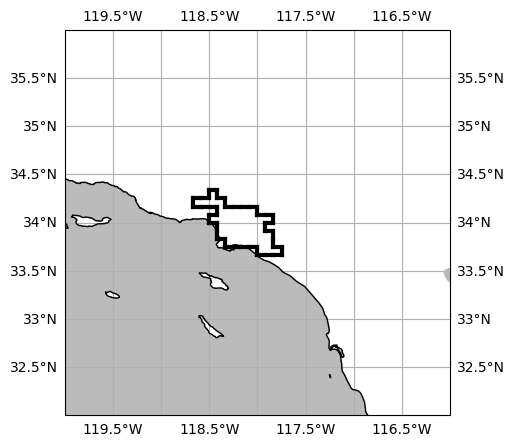

In [6]:
#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='black', inner_color='black', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    if ax is None:
        # figure
        fig = plt.figure(figsize=(5,5))
        ax = plt.subplot(projection=projection)
        ax.coastlines(zorder=1)
        ax.set_extent(extent)
        ax.gridlines(draw_labels=True, zorder=0)
        ax.add_feature(cfea.OCEAN, color='#BBBBBB')
        ax.add_feature(cfea.LAKES, color='#BBBBBB')
        
    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # right
        
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    if ax is None:
        plt.show()
    else:
        return ax

draw_mask_sotowaku(result[0], result[1])

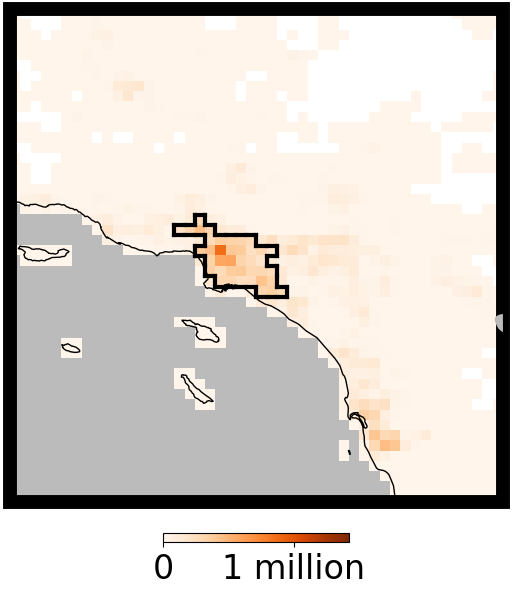

In [7]:

#---------------------------------------------------------------------------------------------------------------
# 人口をプロットする
#---------------------------------------------------------------------------------------------------------------
def plot_population(extent, citymask, g_pop_cropped, country_name=None, gs_position=None, fig=None):
    # draw
    g_pop_cropped = np.ma.masked_where(g_pop_cropped == 0, g_pop_cropped)
    pop_vmin = np.min(g_pop_cropped)
    pop_vmax = np.max(g_pop_cropped)
    #print(f"pop_vmin: {pop_vmin}")
    #print(f"pop_vmax: {pop_vmax}")
    
    # extent
    projection = ccrs.PlateCarree()
    
    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
    else:
        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=0)
    #gl.top_labels = False 
    #gl.top_labels = False   
    #gl.bottom_labels = False   
    #gl.right_labels = False 
    #gl.left_labels = False 
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=1)
    
    img = ax.imshow(g_pop_cropped,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap='Oranges',
                #norm=colors.LogNorm(vmin=1e4, vmax=pop_vmax)
                vmin=0, vmax=1e6,
    ) 
    stw = draw_mask_sotowaku(extent, citymask, ax=ax, sotowaku_color='black') 
    
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)
    
    if country_name is not None:
        shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
        provinces = shapereader.Reader(shpfilename).records()
        provinces_of_japan = filter(
            lambda province: province.attributes['admin'] == country_name, provinces)
        for province in provinces_of_japan:
            geometry = province.geometry
            ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=10)
            
    #fig.colorbar(img, ax=ax, orientation='vertical', shrink=1, pad=0.08)
    if gs_position is None:
        cbar = fig.colorbar(img, ax=ax, orientation='horizontal', shrink=0.3, pad=0.05)
        #cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.3, pad=0.05)
        cbar.set_ticks([0, 700000])
        cbar.set_ticklabels(['0', '1 million'])
        cbar.ax.tick_params(labelsize=24)
        
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

plot_population(result[0], result[1], result[2], country_name='Japan')

/tmp/ipykernel_3899/233728939.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  terrain = plt.cm.get_cmap('terrain')


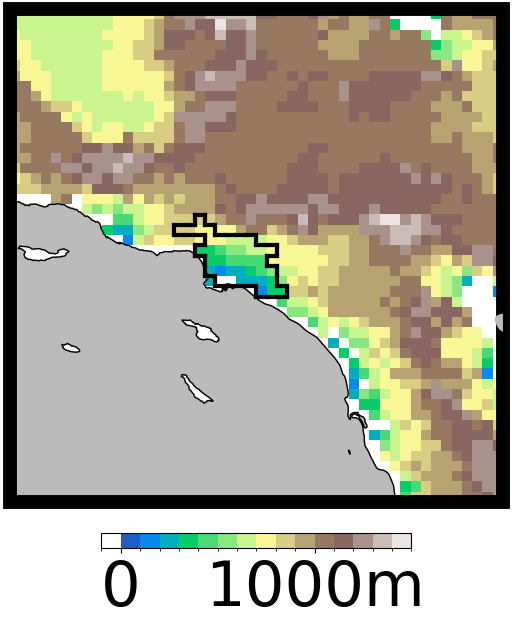

In [8]:
#---------------------------------------------------------------------------------------------------------------
# 標高をプロットする
#---------------------------------------------------------------------------------------------------------------
def plot_elevation(extent, citymask, elevation, gs_position=None, fig=None):
    # draw
    elevation = np.ma.masked_where(elevation == 0, elevation)
    elv_vmin = np.min(elevation)
    elv_vmax = np.max(elevation)
    #print(f"elv_vmin: {elv_vmin}")
    #print(f"elv_vmax: {elv_vmax}")

    terrain = plt.cm.get_cmap('terrain')
    colors = terrain(np.linspace(0, 1, terrain.N))
    colors[0] = (1, 1, 1, 1)
    colors = colors[:-10]
    cmap = mcolors.LinearSegmentedColormap.from_list('terrain_without_white', colors, terrain.N)
    levels = [-1000, 0, 1, 5, 10, 20, 30, 50, 100, 200, 300, 500, 800, 1000, 1500, 2000, 2500]
    norm = mcolors.BoundaryNorm(levels, cmap.N)
    
    # extent
    projection = ccrs.PlateCarree()
    
    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
    else:
        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=0)
    #gl.top_labels = False   
    #gl.top_labels = False   
    #gl.bottom_labels = False   
    #gl.right_labels = False 
    #gl.left_labels = False 
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=1)
    
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)
    
    img = ax.imshow(elevation,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap=cmap,
                norm=norm,
    ) 
    stw = draw_mask_sotowaku(extent, citymask, ax=ax) 
    if gs_position is None:
        cbar = fig.colorbar(img, ax=ax, ticks=levels, orientation='horizontal', shrink=0.5, pad=0.05)
        #cbar.ax.xaxis.set_tick_params(rotation=90)
        cbar.set_ticks([0, 500])
        cbar.set_ticklabels(['0', '1000m'])
        cbar.ax.tick_params(labelsize=45)

    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

plot_elevation(result[0], result[1], result[3])

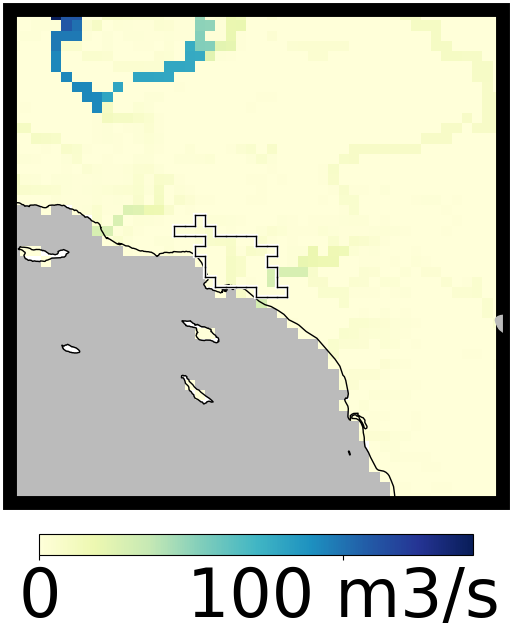

In [9]:
#---------------------------------------------------------------------------------------------------------------
# 集水面積をプロットする
#---------------------------------------------------------------------------------------------------------------
def plot_rivara(extent, citymask, rivara, gs_position=None, fig=None):
    # draw
    # river area was in the unit of m2 
    rivara = np.ma.masked_where(rivara == 0, rivara)
    dis_vmin = np.min(rivara)
    dis_vmax = np.max(rivara)
    #print(f"dis_vmin: {dis_vmin}")
    #print(f"dis_vmax: {dis_vmax}")
    
    # extent
    projection = ccrs.PlateCarree()
    
    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
    else:
        fig = plt.figure(figsize=(8,8))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=0)
    #gl.top_labels = False   
    #gl.top_labels = False   
    #gl.bottom_labels = False   
    #gl.right_labels = False 
    #gl.left_labels = False 
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=1)
    
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)
    
    img = ax.imshow(rivara,
                origin='upper',
                extent=extent,
                transform=projection,
                cmap='YlGnBu',
                #norm=mcolors.LogNorm()
                vmin=0, vmax=1e5,
    ) 
    stw = draw_mask_sotowaku(extent, citymask, sotowaku_color='white', ax=ax) 
    if gs_position is None:
        cbar = fig.colorbar(img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.05)
        cbar.set_ticks([0, 0.7e5])
        cbar.set_ticklabels(['0', '100 m3/s'])
        cbar.ax.tick_params(labelsize=48)
        
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

#plot_rivara(result[0], result[1], result[4]) # rivara [m2]
plot_rivara(result[0], result[1], result[5]) # discharge [kg/s]

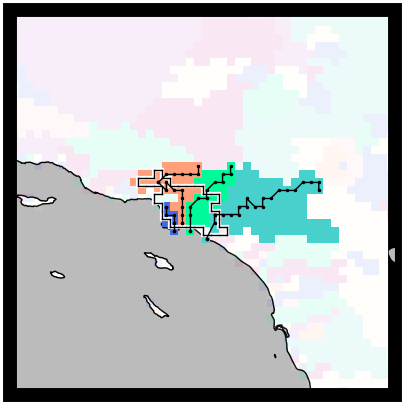

In [10]:
import random
#---------------------------------------------------------------------------------------------------------------
#  BasinとMain riverの図を作図する
#  dark = foregroundg
#  light = background
#---------------------------------------------------------------------------------------------------------------
def plot_basin_path_foreback(extent, citymask, data_fore, data_back, Rivnum_masked_array, results_dict_fore=None, results_dict_back=None, gs_position=None, fig=None):
    # highlight basin
    unique_fore = np.unique(data_fore)
    filtered_fore = [i for i in unique_fore if i != 0]
    
    # cmap
    color_code_fore = ['#4169e1', '#fffacd', '#c71585', '#00fa9a', '#ba55d3', '#48d1cc', '#ffc0cb', '#ffa07a']
    random.seed(7)
    random.shuffle(color_code_fore)
    
    color_masked_fore = np.ma.masked_where(~np.isin(Rivnum_masked_array, filtered_fore), Rivnum_masked_array)
    color_filled_fore = color_masked_fore.filled(-1)
    num_colors_fore, index_dict_fore, cmap_fore = pulp_cmap(color_filled_fore, color_code_fore)
    
    color_code_back = ['#4169e1', '#fffacd', '#c71585', '#00fa9a', '#ba55d3', '#48d1cc', '#ffc0cb', '#ffa07a']
    color_masked_back = np.ma.masked_where(Rivnum_masked_array >= 1e20, Rivnum_masked_array)
    color_filled_back = color_masked_back.filled(-1)
    num_colors_back, index_dict_back, cmap_back = pulp_cmap(color_filled_back, color_code_back)

    # data
    data_masked_fore = np.ma.masked_where(data_fore >= 1e20, data_fore)
    data_filled_fore = data_masked_fore.filled(-1)
    indexed_data_fore = np.vectorize(get_index)(data_filled_fore, index_dict_fore)
    indexed_data_masked_fore = np.ma.masked_where(indexed_data_fore<0, indexed_data_fore)
    
    data_masked_back = np.ma.masked_where(data_back >= 1e20, data_back)
    data_filled_back = data_masked_back.filled(-1)
    indexed_data_back = np.vectorize(get_index)(data_filled_back, index_dict_back)
    indexed_data_masked_back = np.ma.masked_where(indexed_data_back<0, indexed_data_back)
    
    # extent
    projection = ccrs.PlateCarree()

    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
    else:
        fig = plt.figure(figsize=(5,5))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=-1)
    #gl.top_labels = False   
    #gl.bottom_labels = False   
    #gl.right_labels = False 
    #gl.left_labels = False 
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=0)
    
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)
    
    img_back = ax.imshow(indexed_data_masked_back,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap_back,
                    vmin=-0.5, vmax=num_colors_back-0.5,
                    alpha=0.1)
    
    img_fore = ax.imshow(indexed_data_masked_fore,
                    origin='upper',
                    extent=extent,
                    transform=projection,
                    cmap=cmap_fore,
                    vmin=-0.5, vmax=num_colors_fore-0.5,
                    alpha=1.0)
    
    if results_dict_fore is not None:
        width = 1
        for key, path in results_dict_fore.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + extent[0] for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=1.5, color='black', linestyle='-', linewidth=1, transform=projection, zorder=2)
            
    stw = draw_mask_sotowaku(extent, citymask, sotowaku_color='white', ax=ax) 
    
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)
    
plot_basin_path_foreback(result[0], result[1], result[10], result[6], result[6], results_dict_fore=result[29], results_dict_back=result[25])

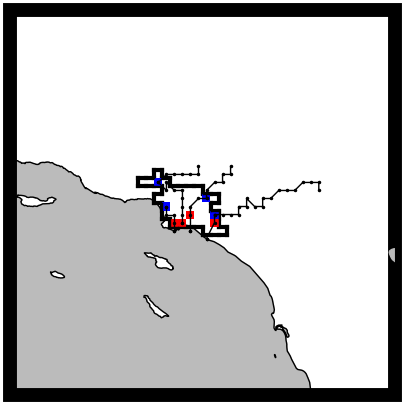

In [11]:
#---------------------------------------------------------------------------------------------------------------
#  上下水道のプロット
#---------------------------------------------------------------------------------------------------------------
def plot_prf_swg(extent, citymask, prf, swg, results_dict=None, gs_position=None, fig=None):
    # mask
    prf = np.ma.masked_where(prf == 0, prf)
    swg = np.ma.masked_where(swg == 0, swg)

    # cmap
    prf_cmap = colors.ListedColormap(['blue', 'blue'])
    swg_cmap = colors.ListedColormap(['red', 'red'])
    
    # extent
    projection = ccrs.PlateCarree()
    
    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
    else:
        fig = plt.figure(figsize=(5,5))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=0)
    #gl.top_labels = False   
    #gl.bottom_labels = False   
    #gl.right_labels = False 
    #gl.left_labels = False 
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=0)
    
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)

    p_img = ax.imshow(prf,
                    origin='upper', extent=extent, transform=projection,
                    cmap=prf_cmap,
                    zorder=2
                   )
    s_img = ax.imshow(swg,
                    origin='upper', extent=extent, transform=projection,
                    cmap=swg_cmap,
                    zorder=2
                   )
    
    stw = draw_mask_sotowaku(extent, citymask, ax=ax, sotowaku_color='black') 
    
    if results_dict is not None:
        width = 1
        for key, path in results_dict.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + extent[0] for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=1.5, color='black', linestyle='-', linewidth=1, transform=projection, zorder=2)
    
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

plot_prf_swg(result[0], result[1], result[20], result[21], results_dict=result[29])

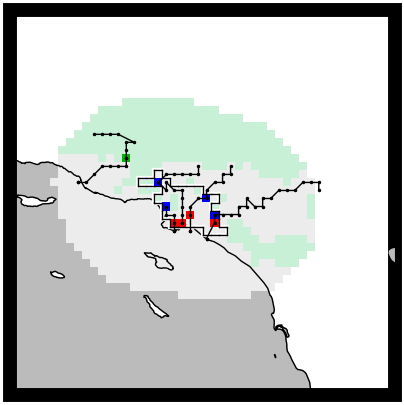

In [12]:
img_extent, rgnshape, upperindex, lowerindex, leftindex, rightindex = geography(*result[0])
camadir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity'

# city mask
mask = np.fromfile(f'{camadir}/dat/cty_msk_/city_clrd0000.gl5', dtype='float32').reshape(2160, 4320)
mask = np.where(mask==city_num, 1, 0)
mask_cropped = mask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# candidate intake
exp_cand = np.fromfile(f'{camadir}/dat/cty_aqd_/fig_100km_elevation/intake_display_{city_num:08}.gl5', dtype='float32').reshape(2160, 4320)
exp_cand_cropped = exp_cand[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
exp_cand_masked = np.ma.masked_where(exp_cand_cropped==0, exp_cand_cropped)

# estimated intake
intake = np.fromfile(f'{camadir}/dat/cty_aqd_/100km_elevation/city_{city_num:08}.gl5', dtype='float32').reshape(2160, 4320)
intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# josui
josui = np.fromfile(f'{camadir}/dat/cty_prf_/prf_clrd0000.gl5', dtype='float32').reshape(2160, 4320)
josui = np.where(josui==city_num, 1, 0)
josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# gesui
gesui = np.fromfile(f'{camadir}/dat/cty_swg_/swg_clrd0000.gl5', dtype='float32').reshape(2160, 4320)
gesui = np.where(gesui==city_num, 1, 0)
gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# explored file
# 1: explored area
# 2: candidate points

def plot_ibt(extent, citymask, exp_cand, intake, prf, swg, results_dict=None, gs_position=None, fig=None):
    cm = colors.ListedColormap(["#ececec", "#c7f0d7"])
    cmap_intake = colors.ListedColormap(['none', '#00b500'])
    cmap_josui = colors.ListedColormap(['none', 'blue'])
    cmap_gesui = colors.ListedColormap(['none', 'red'])

    # extent
    projection = ccrs.PlateCarree()

    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
    else:
        fig = plt.figure(figsize=(5, 5))
        ax = plt.subplot(projection=projection)

    ax.set_extent(extent, projection)
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=1)

    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)

    im = ax.imshow(exp_cand_masked, extent=img_extent, transform=projection, cmap=cm, vmin=1, vmax=2, zorder=0)
    im2 = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=2)
    im3 = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=cmap_josui, zorder=2)
    im4 = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=cmap_gesui, zorder=2)
    draw_mask_sotowaku(img_extent, mask_cropped, ax=ax, sotowaku_color='white')

    """
    # tokyo shapefile
    shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
    provinces = shapereader.Reader(shpfilename).records()
    provinces_of_japan = filter(
        lambda province: province.attributes['admin'] == 'Japan', provinces)
    for province in provinces_of_japan:
        geometry = province.geometry
        ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=0)
    """
    
    if results_dict is not None:
        width=1
        for key, path in results_dict.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + extent[0] for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=1.5, color='black', linestyle='-', linewidth=1, transform=projection, zorder=2)

    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)
    
plot_ibt(result[0], result[1], exp_cand_masked, intake_cropped, josui_cropped, gesui_cropped, results_dict=result[30])

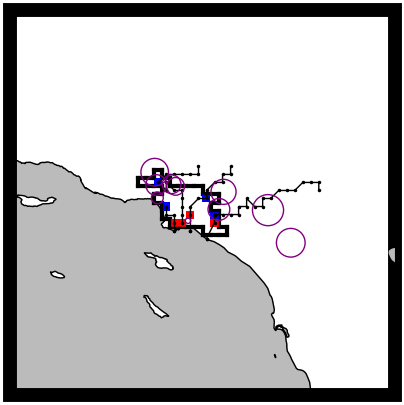

In [15]:
#---------------------------------------------------------------------------------------------------------------
#  上下水道のプロット
#---------------------------------------------------------------------------------------------------------------
    
def plot_jogesui_comparison(extent, citymask, prf, swg, josui_csv, fcl_josui, results_dict=None, gs_position=None, fig=None):
    #mask
    prf = np.ma.masked_where(prf == 0, prf)
    swg = np.ma.masked_where(swg == 0, swg)
    
    prf_cmap = colors.ListedColormap(['blue', 'blue'])
    swg_cmap = colors.ListedColormap(['red', 'red'])
        
    projection = ccrs.PlateCarree()
    
    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
            
    else:
        fig = plt.figure(figsize=(5,5))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=0)
    #gl.top_labels = False   # Turn off top x-axis labels
    #gl.right_labels = False # Turn off right y-axis labels
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines()
    
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)

    p_img = ax.imshow(prf,
                    origin='upper', extent=extent, transform=projection,
                    cmap=prf_cmap,
                    zorder=2
                   )
    s_img = ax.imshow(swg,
                    origin='upper', extent=extent, transform=projection,
                    cmap=swg_cmap,
                    zorder=2
                     )
    magnif = 1
    size_list = [1 if pd.isna(i) or np.isinf(i) else float(i*magnif) for i in josui_csv['capacity']]
    im4 = ax.scatter(josui_csv['lon'], josui_csv['lat'], 
                     s = size_list,
                     color='purple', zorder=4, facecolor='none')
    stw = draw_mask_sotowaku(extent, citymask, ax=ax, sotowaku_color='black') 
    
    if results_dict is not None:
        width=1
        for key, path in results_dict.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + extent[0] for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=1.5, color='black', linestyle='-', linewidth=1, transform=projection, zorder=2)

    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)
    
plot_jogesui_comparison(result[0], result[1], result[20], result[21], result[22], result[23], results_dict=result[29])

/tmp/ipykernel_3899/233728939.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  terrain = plt.cm.get_cmap('terrain')


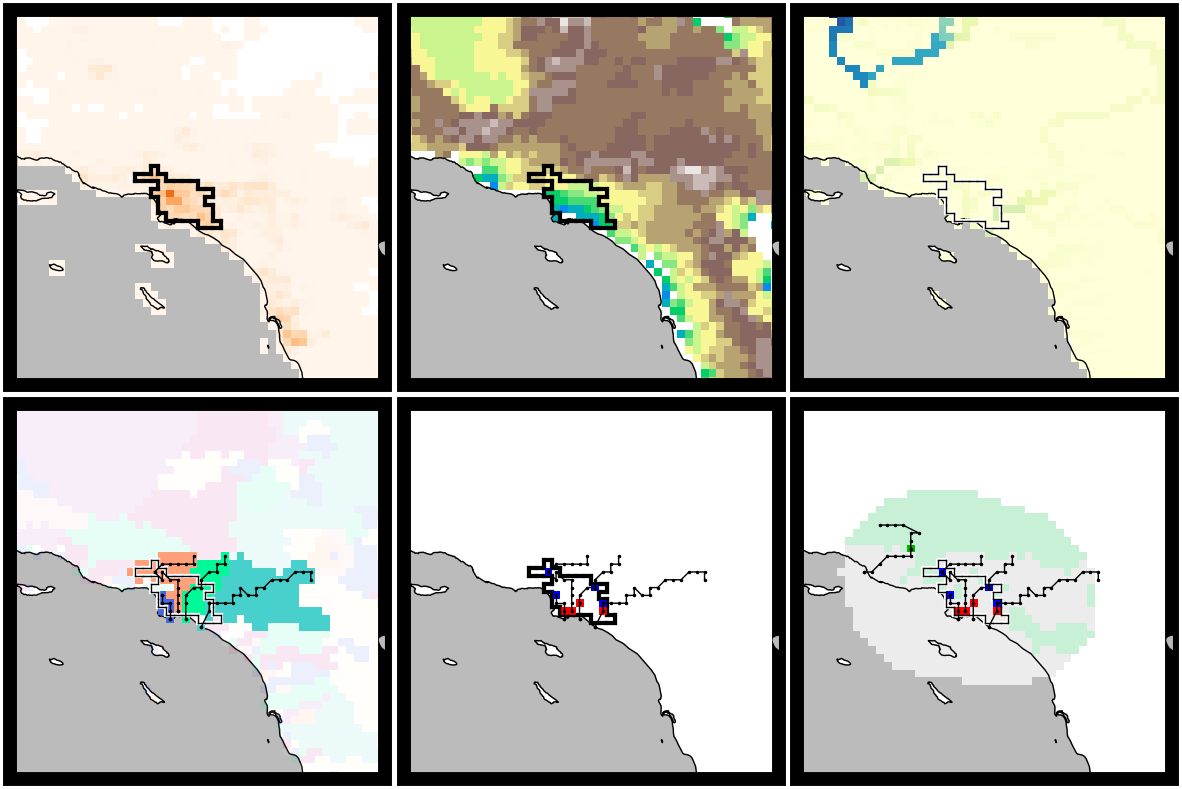

In [14]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, wspace=0.05, hspace=0.05)

plot_population(result[0], result[1], result[2], country_name='Japan', gs_position=gs[0,0], fig=fig)
plot_elevation(result[0], result[1], result[3], gs_position=gs[0,1], fig=fig)
plot_rivara(result[0], result[1], result[5], gs_position=gs[0,2], fig=fig)
plot_basin_path_foreback(result[0], result[1], result[10], result[6], result[6], results_dict_fore=result[29], results_dict_back=result[25], gs_position=gs[1,0], fig=fig)
plot_prf_swg(result[0], result[1], result[20], result[21], results_dict=result[29], gs_position=gs[1,1], fig=fig)
plot_ibt(result[0], result[1], exp_cand_masked, intake_cropped, josui_cropped, gesui_cropped, results_dict=result[30], gs_position=gs[1,2], fig=fig)

plt.show()

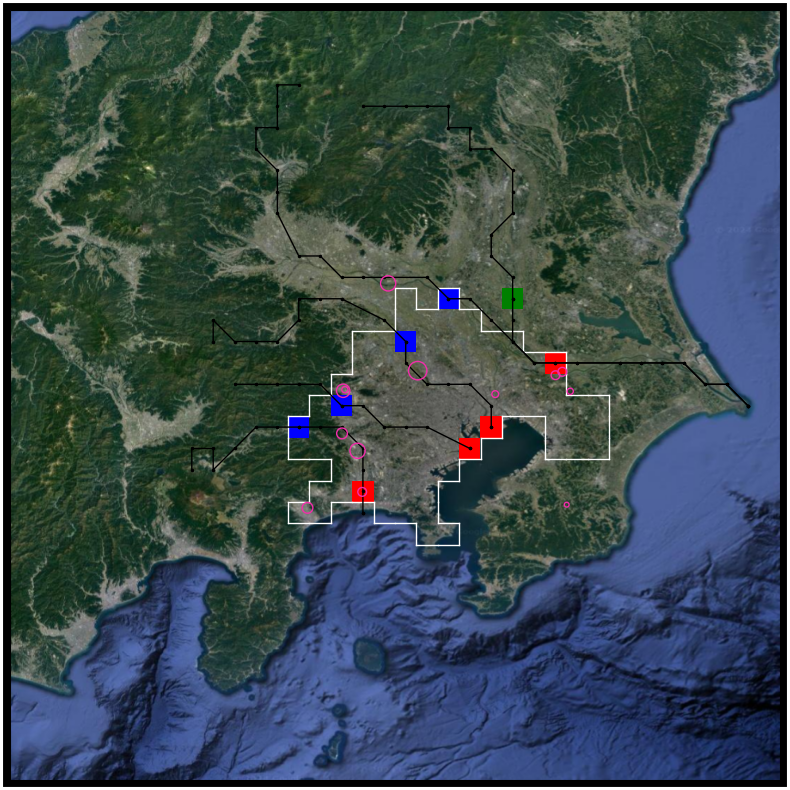

In [289]:
#---------------------------------------------------------------------------------------------------------------
# google earth satellite validation
from PIL import Image
#---------------------------------------------------------------------------------------------------------------
    
def validation(extent, citymask, prf, swg, intake, josui_csv, fcl_josui, results_dict=None, gs_position=None, fig=None):
    # gee
    # これの作り方がnotionに書いてある気がする
    #--------------------------------------------------
    #gee_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/qgis/dat/screenshot/tokyo20240927.tiff'
    image = Image.open(gee_path)
    ref_data = np.array(image)
    #--------------------------------------------------
    
    #mask
    prf = np.ma.masked_where(prf == 0, prf)
    swg = np.ma.masked_where(swg == 0, swg)
    
    prf_cmap = colors.ListedColormap(['blue', 'blue'])
    swg_cmap = colors.ListedColormap(['red', 'red'])
    intake_cmap = colors.ListedColormap(['green', 'green'])
        
    projection = ccrs.PlateCarree()
    
    if gs_position is not None:
        ax = fig.add_subplot(gs_position, projection=projection)
            
    else:
        fig = plt.figure(figsize=(10,10))
        ax = plt.subplot(projection=projection)
        
    ax.set_extent(extent, projection)
    #gl = ax.gridlines(draw_labels=True, zorder=0)
    #gl.top_labels = False   # Turn off top x-axis labels
    #gl.right_labels = False # Turn off right y-axis labels
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines()

    # outer
    rect = plt.Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes,
        linewidth=10, edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(rect)
    
    # gee
    gee_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/qgis/dat/tokyo20240927.tiff'
    image = Image.open(gee_path)
    ref_data = np.array(image)
    ax.imshow(ref_data, origin='upper', extent=extent, transform=projection, zorder=2)

    # prf
    p_img = ax.imshow(prf,
                    origin='upper', extent=extent, transform=projection,
                    cmap=prf_cmap,
                    zorder=2
                   )
    # swg
    s_img = ax.imshow(swg,
                    origin='upper', extent=extent, transform=projection,
                    cmap=swg_cmap,
                    zorder=2
                     )

    # int
    intake = np.ma.masked_where(intake==0, intake)
    s_img = ax.imshow(intake,
                    origin='upper', extent=extent, transform=projection,
                    cmap=intake_cmap,
                    zorder=2
                     )

    # validation points
    magnif = 4
    size_list = [1 if pd.isna(i) or np.isinf(i) else float(i*magnif) for i in josui_csv['capacity']]
    im4 = ax.scatter(josui_csv['lon'], josui_csv['lat'], 
                     s = size_list,
                     color='#f32dac', zorder=4, facecolor='none')

    # citymask
    stw = draw_mask_sotowaku(extent, citymask, ax=ax, sotowaku_color='white', inner_color='white') 

    # rivpath
    if results_dict is not None:
        width=1
        for key, path in results_dict.items():
            lat_coords, lon_coords = zip(*path)
            lat_coords = [extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + extent[0] for lon in lon_coords]
            ax.plot(lon_coords, lat_coords, marker='o', markersize=1.5, color='black', linestyle='-', linewidth=1, transform=projection, zorder=2)

validation(result[0], result[1], result[20], result[21], result[31], result[22], result[23], results_dict=result[30])